<a href="https://colab.research.google.com/github/MarkStephens060482/forecasting_BEV_adoption_LGA/blob/main/Uptake_of_Electric_Vehicles_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uptake of Electric Vehicles at LGA level - Exploratory Data Analysis
### Enhancing Sustainable Transportation Planning through Explainable Electric Vehicle Adoption Forecasting in Ausrralian Local Governments.
1. Define Outcome Variable, BEV share per 1000 people.
1. Examine spatial representation of outcome variable, represent BEV share at LGA level on map of Australia and examine time variation.

In [205]:
!pip install geopandas plotly seaborn

Import modules and set path

In [206]:
import geopandas as gpd
import numpy as np, pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import drive
import os
from pathlib import Path
from IPython.core.display import HTML
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import re

drive.mount('/content/drive')

#%load_ext cudf.pandas
# Set the working directory to a specific path
cwd = os.getcwd()
PATH = "/content/drive/MyDrive/Masters Data Science work/Masters of Data Science Study/Masters Program/Capstone Project"
os.chdir(PATH)
# Define the new directory path
new_dir = Path(cwd +"/EDA")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Initial Exploratory Data Analysis
## Examine the Target Variable
### Vehicle Type and Fuel Type categories per State 2013 - 2021
Examine the context of the Outcome variables.
1. How do Passenger BEVs fit in to broader electric vehicle counts?
Produce segmented bar charts of all registered electric vehicles across Australia over the years.
2. What proportion of registered electric vehicles are passeneger vehicles?


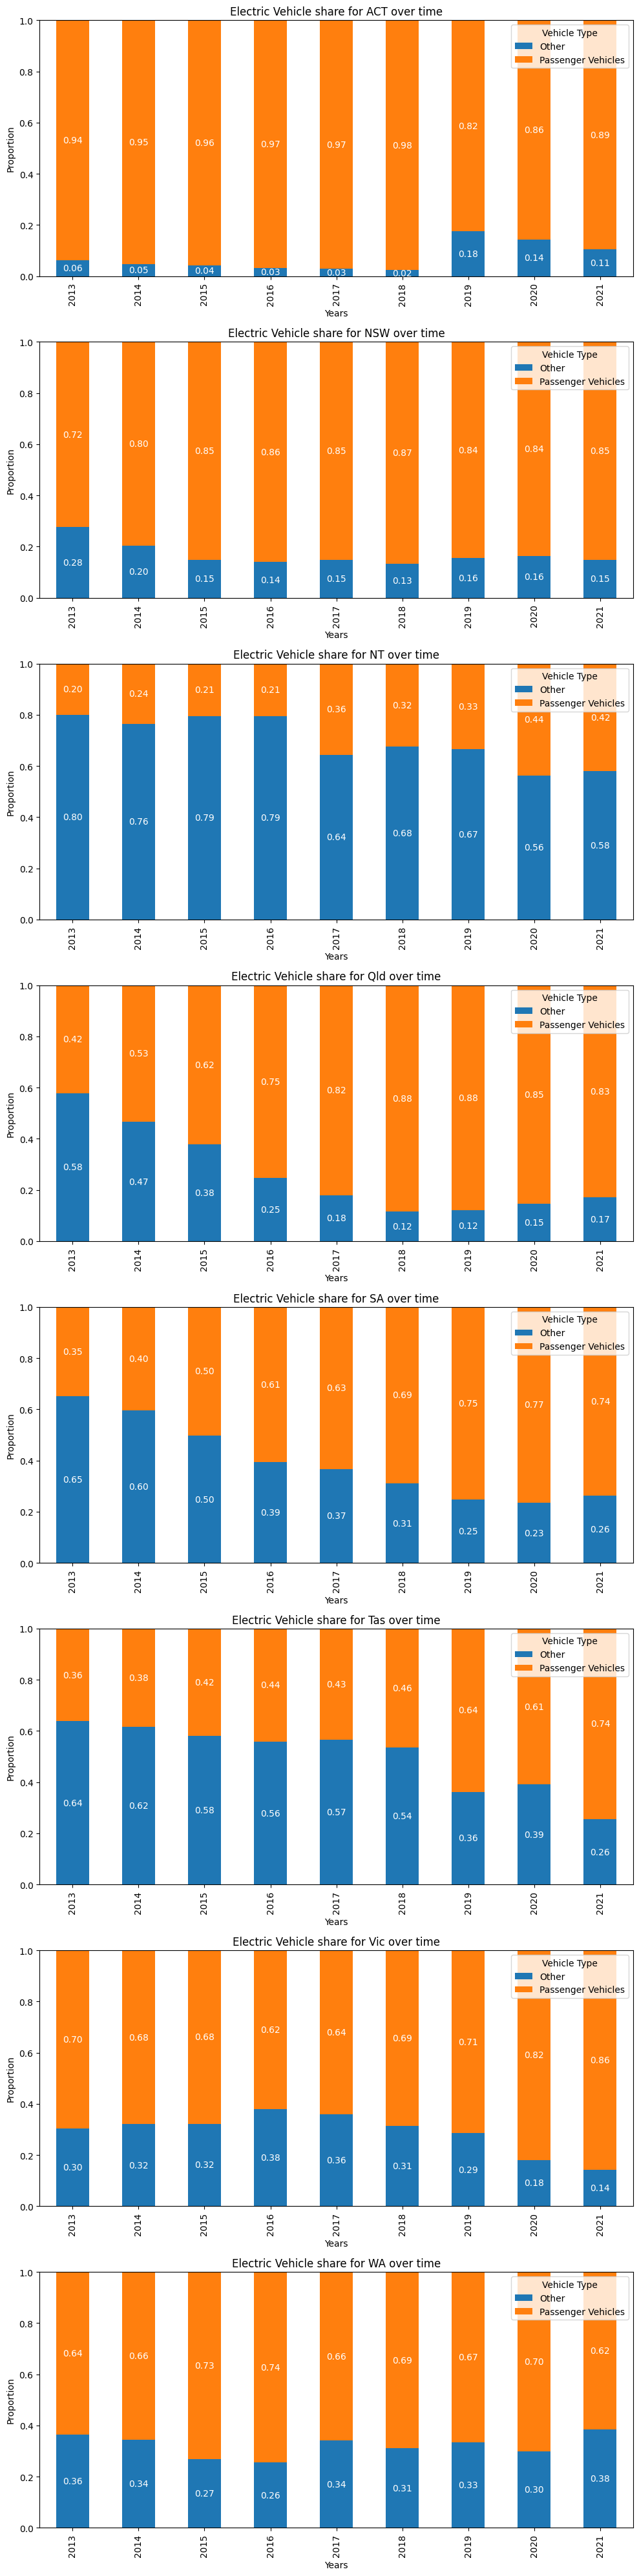

In [207]:
# read the csv files one at a time and concatenate to a dataframe.
dfs = []
for file in os.listdir(PATH +"/EV data/"):
    # Extract the number from the filename using regular expressions
    year = re.search(r'\d+', file).group()
    with open(PATH+"/EV data/"+file,encoding="utf-8") as dataFile:
      df = pd.read_csv(dataFile,index_col=False)
    # Add a new column 'year' with the extracted number\
    df['Year'] = int(year)
    dfs.append(df)
EV_df = pd.concat(dfs)

EV_df.drop(columns = ['Not Applicable','Diesel','Petrol','LPG/Dual fuel','Other and unknown'],inplace = True)
# Determine the frequency of each category in column 'A'
EV_df['Vehicle type'] = EV_df['Vehicle type'].apply(lambda x: x if x == "Passenger Vehicles" else "Other")
EV_df_grouped = EV_df.groupby(['Year','State','Vehicle type'])[['Electric','Total']].sum()
EV_df_grouped2 = EV_df_grouped.groupby(['Year','State'])[['Electric','Total']].sum()
# Define a threshold to identify rare categories
#threshold = 2

EV_prop_df = pd.concat([EV_df_grouped.reset_index(level = 2)[['Electric','Total']]/EV_df_grouped2[['Electric','Total']],EV_df_grouped.reset_index(level = 2)['Vehicle type']], axis = 1)
EV_prop_df = EV_prop_df.set_index('Vehicle type', append = True)

# Group the DataFrame by the first level index (Year)
grouped = EV_prop_df.groupby(level=1)

# Number of subplots
n_subplots = len(grouped)

# Create subplots
fig, axes = plt.subplots(nrows=n_subplots, ncols=1, figsize=(10, 5 * n_subplots))

# Iterate through each group to create a subplot
for (state, group), ax in zip(grouped, axes.flatten()):
    # Unstack the DataFrame to get the second level index (Category) as x-values and third level index (Type) as the stack
    pivot_table = group['Electric'].unstack(level=2).fillna(0)

    # Plot the stacked bar plot
    pivot_table.plot(kind='bar', stacked=True, ax=ax)

    # Set x-labels as level 1 index only
    x_labels = pivot_table.index.get_level_values(0)
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_xticklabels(x_labels)

    # Annotate with formatted values
    for i, (_, row) in enumerate(pivot_table.iterrows()):
        bottom = 0
        for category, value in row.items():
            ax.text(i, bottom + value / 2, f'{value:.2f}', ha='center', va='center', color='white')
            bottom += value

    # Set subplot title and labels
    ax.set_title(f'Electric Vehicle share for {state} over time')
    ax.set_xlabel('Years')
    ax.set_xticks
    ax.set_ylabel('Proportion')
    ax.legend(title='Vehicle Type')
    ax.set_ylim(0,1)

# Adjust layout
plt.tight_layout()
plt.show()

# Analytical and Auxiliary Multivariate Analysis

Clean data set and prepare for analysis

In [208]:
# Change the current working directory to the new directory
dfs=[]
for file in list(new_dir.glob("*.csv")):
  with open(file,encoding="latin1") as dataFile:
        df = pd.read_csv(dataFile,index_col=False)
  dfs.append(df)

# define Analytical Variables
Analytical_df = dfs[0]
#define charging
Auxiliary_df = dfs[1]
#set LGA_code as string
Auxiliary_df['LGA_code'] = Auxiliary_df['LGA_code'].astype(str)
#Set LGA_code as index
Auxiliary_df = Auxiliary_df.set_index('LGA_code')

# Read the shapefile
geodf = gpd.read_file(list(new_dir.glob("*.shp"))[0])
# shape file is a different CRS,  change to lon/lat GPS co-ordinates
geodf = geodf.to_crs(epsg=4326)
# simplify geometry to 250m accuracy
geodf["geometry"] = (
    geodf.to_crs(geodf.estimate_utm_crs()).simplify(250).to_crs(geodf.crs)
)

#Clean geodf
geodf = geodf.rename(columns={"LGA_CODE22": "LGA_code",
                             "LGA_NAME22": "LGA_name"})
Analytical_df = Analytical_df.astype({"LGA_code": str}) # convert LGA_code to int
geodf = geodf[(geodf["LGA_code"].isin(Analytical_df["LGA_code"]))]

# set LGA_code as index
geodf = geodf.set_index("LGA_code")
Analytical_df = Analytical_df.set_index("LGA_code")

### Data Description and distributions


In [209]:
# Open the pickled file and load the data
file_path = 'data_dict.pickle'
with open(file_path, 'rb') as file:
    data_dict = pickle.load(file)
data_dict['Fast_DC_chargers'] = "The number of fast CD chargers in LGA"
data_dict['Electric'] = "The number of passenger electric vehicles in LGA"
data_dict['Total'] = "The total number of passenger vehicles in LGA"
data_dict['EV_prop'] = "The proportion of passenger electric vehicles per 1000 people in LGA"
data_dict['Electoral Rating'] = "The electoral rating of the LGA region"
data_dict['Official Name State'] = "The official name of the state in which the LGA is located"
data_dict['Longitude'] = "The longitude of the centroid of the LGA"
data_dict['Latitude'] = "The latitude of the centroid of the LGA"
data_dict['LGA_name'] = "The name of the LGA"
data_dict['LGA_code'] = "The code of the LGA"
data_dict['Year'] = "The year of the data"
data_dict['Distance_capital'] = "The distance from the LGA to the capital city for the state."
data_dict['Higher_Education'] = "The percentage of the population with a higher education level."
data_dict['Rooftop_Solar'] = 'Number of premises with small-scale rooftop solar panels.'
data_dict['High_income'] =  'The percentage of the population with high income, greater than $2000 per week.'
data_dict['Tech_Affinity'] = 'percentage of professionally employed as a proxy for technological affinity.'
data_dict['Greens_Vote_prop'] = 'The proportion of first preference vote for Australian Greens Party.'
data_dict['Neighbourhood_EV_prop'] = 'The proportion of existing neighbourhood electric vehicles per 1000 people as a proxy for the neighbourhood effect.'
print(Analytical_df.info())
for k,v in data_dict.items():
  print(k+": "+v)
Analytical_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 7007 entries, 10050 to 89399
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   7007 non-null   int64  
 1   Official Name State    7007 non-null   object 
 2   LGA_name               7007 non-null   object 
 3   Fast_DC_chargers       7007 non-null   int64  
 4   Distance_capital       7007 non-null   float64
 5   Higher_Education       1529 non-null   float64
 6   Rooftop_Solar          4687 non-null   float64
 7   High_income            1067 non-null   float64
 8   Tech_Affinity          1617 non-null   float64
 9   Greens_Vote_prop       2156 non-null   float64
 10  EV_prop                7007 non-null   float64
 11  Neighbourhood_EV_prop  7007 non-null   float64
dtypes: float64(8), int64(2), object(2)
memory usage: 711.6+ KB
None
BD_3: Total fertility rate (births per female) (rate)
CABEE_10: Total business entries (no.)
CAB

,Year,Fast_DC_chargers,Distance_capital,Higher_Education,Rooftop_Solar,High_income,Tech_Affinity,Greens_Vote_prop,EV_prop,Neighbourhood_EV_prop
count,7007.000000,7007.000000,7007.000000,1529.000000,4687.000000,1067.000000,1617.000000,2156.000000,7007.000000,7007.000000
mean,2017.000000,0.283716,351.284495,15.572709,4409.087685,8.933261,16.660420,0.079300,0.494850,0.299754
std,3.741924,1.037271,448.419620,10.810428,9750.244187,6.433535,8.502388,0.058751,1.355673,0.808319
min,2011.000000,0.000000,0.652823,2.400000,3.000000,0.600000,2.500000,0.000000,0.000000,0.000000
25%,2014.000000,0.000000,61.369043,9.000000,341.000000,4.700000,11.300000,0.038756,0.000000,0.000000
50%,2017.000000,0.000000,201.316139,11.400000,1388.000000,7.000000,14.100000,0.065781,0.000000,0.000000
75%,2020.000000,0.000000,417.227845,17.300000,4525.000000,10.850000,19.100000,0.102987,0.393900,0.280505
max,2023.000000,34.000000,2247.708786,59.500000,181279.000000,48.700003,48.800000,0.552323,21.037726,14.925373


## Missing values in Analysis dataset
1. Proportion of missing values in variables

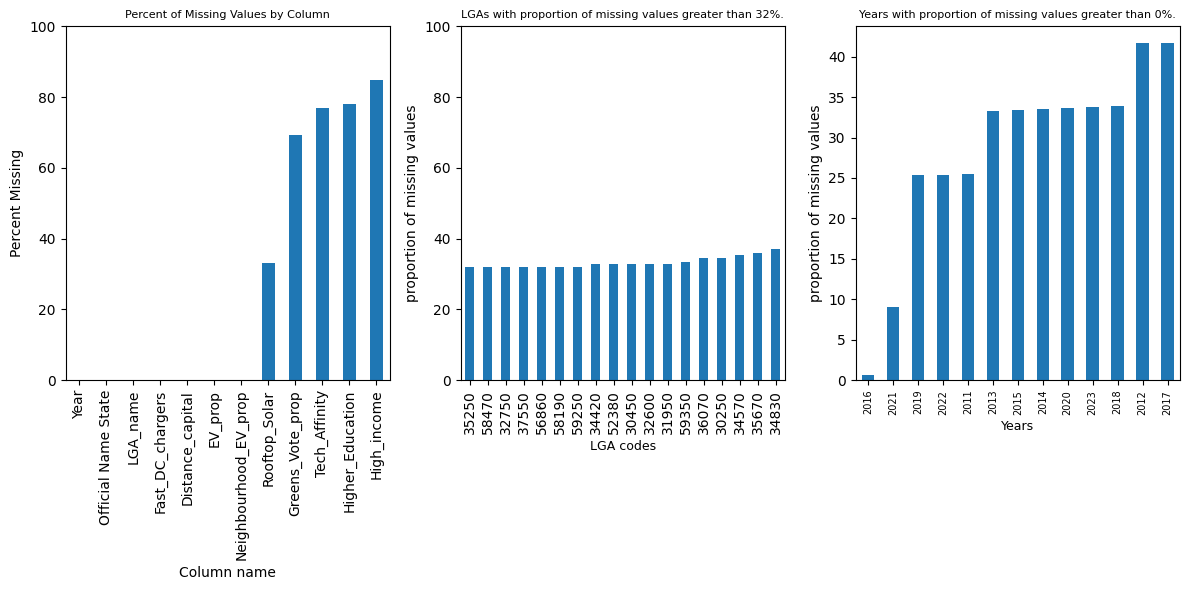

In [210]:
import matplotlib.pyplot as plt
#Helper function proportion of missing values in each Observation (rows)
def missing_proportion(group):
    return group.isnull()
###### PLOT 1
 #Helper function for proportion of missing value variables (columns)
percent_missing = Analytical_df.isnull().sum() * 100 / len(Analytical_df)

# missing values in Variables
variable_missing_value_prop = pd.DataFrame({'column_name': Analytical_df.columns,
                                 'percent_missing': percent_missing})
variable_missing_value_prop.sort_values('percent_missing', inplace=True)
variable_missing_value_prop.reset_index(inplace = True)
variable_missing_value_prop = variable_missing_value_prop.drop(variable_missing_value_prop.columns[0], axis = 1)

# Create a figure and an axis
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12, 6))
# Display missing values
variable_missing_value_prop.sort_values(by = 'percent_missing').plot(kind = 'bar',
                                                               x = 'column_name',
                                                               y = 'percent_missing',
                                                               legend=False,
                                                               ax=ax1)
ax1.set_xlabel('Column name')
ax1.set_ylabel('Percent Missing')
ax1.set_ylim(0,100)
#set title and fontsize
ax1.set_title('Percent of Missing Values by Column', fontsize = 8)

#####
#PLOT 2
####
null_counts = Analytical_df.isnull().groupby(level = "LGA_code").sum().sum(axis = 1)
lga_total_values = len(Analytical_df.columns)*len(Analytical_df['Year'].unique())
lga_prop_miss = pd.DataFrame((100*null_counts/lga_total_values)).rename(columns = {0:'missing_proportion'}).sort_values(by ='missing_proportion').reset_index()
threshold = 32
lga_prop_miss_plot = lga_prop_miss[lga_prop_miss['missing_proportion'] > threshold]
lga_prop_miss_plot_list = lga_prop_miss_plot['LGA_code']
lga_prop_miss_plot.plot(kind = 'bar',
                        x = 'LGA_code',
                        y = 'missing_proportion',
                        legend = False,
                        ax = ax2)
ax2.set_title(f'LGAs with proportion of missing values greater than {threshold}%.', fontsize = 8)
ax2.set_xlabel('LGA codes', fontsize = 9)
ax2.set_ylabel('proportion of missing values')
ax2.set_ylim(0,100)
#####
#PLOT 3
###
plot_df = Analytical_df.reset_index().set_index(['LGA_code','Year']).copy()
null_counts = plot_df.isnull().groupby(level = "Year").sum().sum(axis = 1)
years_total_values = len(Analytical_df.columns)*len(Analytical_df.index.get_level_values('LGA_code').unique())
years_prop_miss = pd.DataFrame((100*null_counts/years_total_values)).rename(columns = {0:'missing_proportion'}).sort_values(by ='missing_proportion').reset_index()

threshold1 = 0
years_prop_miss_plot = years_prop_miss[years_prop_miss['missing_proportion'] > threshold1]
years_prop_miss_plot_list = years_prop_miss_plot['Year']
ax =years_prop_miss_plot.plot(kind = 'bar',
                              x = 'Year',
                              y = 'missing_proportion',
                              legend = False,
                              ax = ax3)
ax3.set_title(f'Years with proportion of missing values greater than {threshold1}%.', fontsize = 8)
ax3.set_xlabel('Years', fontsize = 9)
ax3.set_ylabel('proportion of missing values')
#######
plt.tight_layout()

# Rotate the x-tick labels by 45 degrees
plt.xticks(fontsize=7)
plt.show()

# Analytical Variables and Auxiliary Variables
1. Examine correlations between each analytical variable via bivariate scatterplots and correlation matrix.
2. Examine bivariate relationship with reciprocal distance and EV_prop



### Bivariate and Univariate Analysis of Analytical variables

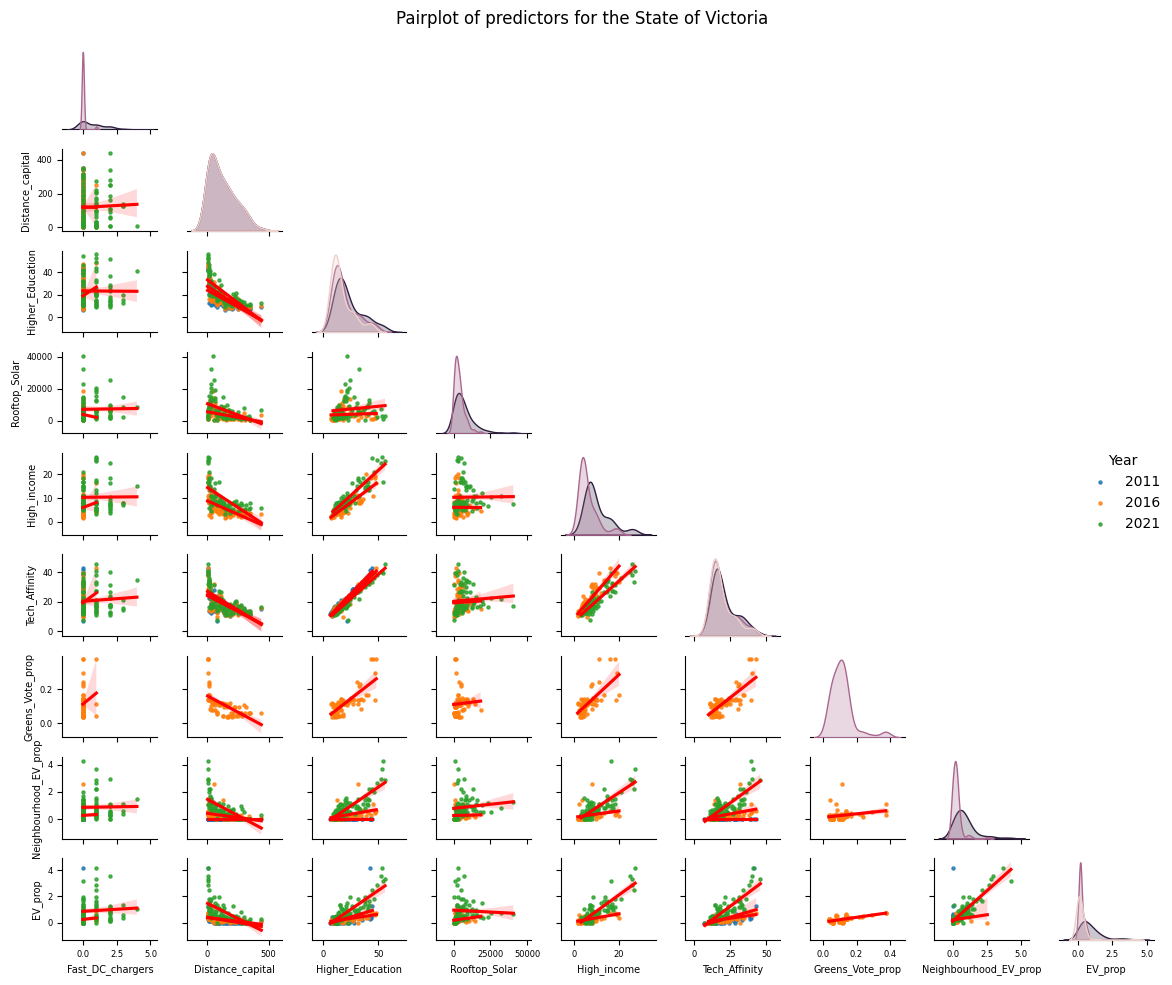

In [211]:
State = "Victoria"
Years_of_interest = [2011,2016,2021]
Analytical_filtered_df = Analytical_df[(Analytical_df['Official Name State']== State)&(Analytical_df['Year'].isin(Years_of_interest))]
# Remove Official State Name
Analytical_filtered_df = Analytical_filtered_df.drop(columns = ['Official Name State'])
cols = Analytical_filtered_df.columns.tolist()
cols.append(cols.pop(cols.index('EV_prop')))
dimensions = Analytical_filtered_df[cols]

# Reset the index to ensure unique labels for the 'Year' column
dimensions = dimensions.reset_index(drop=True)

# Create a figure and an axis
pplot = sns.pairplot(dimensions,
                     diag_kind = 'kde',
                     kind = 'reg',
                     hue = 'Year',
                     plot_kws = {'line_kws':{'color':'red'},
                                 'scatter_kws': {'s':5}
                                 },
                     corner = True,
                     height = 1.1,
                     aspect = 1.1)
# Reduce font size of the facet labels
for ax in pplot.axes.flatten():
  if ax == None:
    continue
  ax.set_xlabel(ax.get_xlabel(), fontsize=7)
  ax.set_ylabel(ax.get_ylabel(), fontsize=7)
  ax.tick_params(axis='both', which='major', labelsize=6)

# Adjust the layout to make room for the title
plt.subplots_adjust(top=0.95)
# Add a title
pplot.fig.suptitle(f'Pairplot of predictors for the State of {State}', y=0.99, fontsize=12)
plt.tight_layout()
plt.show()

### Correlation Heatmap of variables

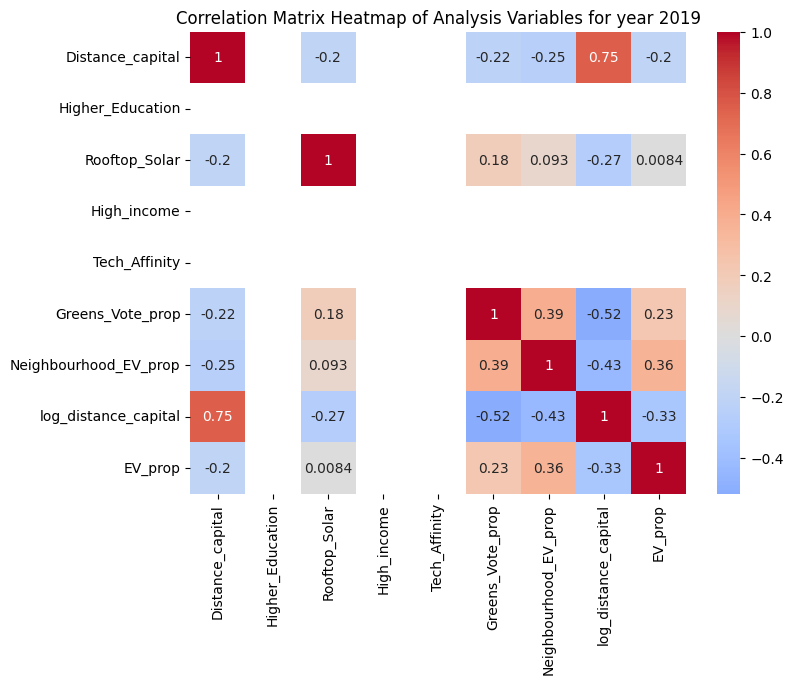

In [237]:
Year = 2019
# filter for the year of interest
plot_df1 = Analytical_df[Analytical_df['Year'] == Year].copy()
#calculate reciprocal distance to capital city
plot_df1['log_distance_capital'] = np.log(plot_df1['Distance_capital'])
# rearrange columns
cols = plot_df1.columns.tolist()
cols.append(cols.pop(cols.index('EV_prop')))
plot_df1 = plot_df1[cols]
# Create a correlation matrix
corr_matrix = plot_df1.iloc[:,4:].corr()
#create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
# Add a title
plt.title(f'Correlation Matrix Heatmap of Analysis Variables for year {Year}')
plt.show()

### Bivariate relationship of EV_prop and Reciprocal Distance

In [213]:
#calculate reciprocal distance to capital city
plot_data2 = Analytical_df[Analytical_df['Official Name State']=='Victoria'].copy()
plot_data2['log_distance_capital'] = np.log(plot_data2['Distance_capital'])
#plt.figure(figsize=(8, 6))
fig = px.scatter(plot_data2,
                 x = "log_distance_capital",
                 y = "EV_prop",
                 color = "Official Name State",
                 animation_frame = "Year",
                 hover_data= {'LGA_name': True},
                 title = "Relationship between log distance to city and BEV share per 1000 people",
                 trendline = 'ols')

fig.update_xaxes(title = "Reciprocal distance to capital city")
fig.update_yaxes(title = "BEV share per 1000 people")
fig.show()

### Transform Distance to Capital

In [263]:
Analytical_df['log_distance_capital'] = np.log(Analytical_df['Distance_capital'])

# Imputation model Auxiliary Variables selection Algorithm - Correlation threshold
parameters:
correlation threshold
top number of correlating candidate variables
candidate variable shortlist threshold
missingness threshold

1. Combine Analysis and Auxiliary variables.
2. Select the variables from Analysis set that have missing values, inclusive of Target variable.
3. For each of these Variables from step 2,
        a. For each year of the dataset,
            i. Compute correlation matrix and filter for variable, sort in descending order.
            ii. form candidate variable set based on correlation threshold or top number of variables.
  b. Determine frequency of candidate variable across all years, sort in descending order.
  c. Calculate Adjusted frequency of the candidate variable by the proportion of missingness according to $f' = \dfrac{f}{1-m}$, where ${m}$ is the proportion of missingness for the candidate variable and ${f}$ is the frequency of the variable.   
  d. If adjusted frequency $f'$ is greater than the shortlist threshold, then add candidate variable to shortlist.
4. Determine the union of all shortlist sets of candidate variables that correlate with Analytical Variables from step 2.
5. Sort the shortlist of candidate variables based on proportion of missingness, and select based on missingness threshold.

OUTPUT:Feature set of Auxiliary variables for imputation model

  

In [343]:
# Auxiliary variable selection algorithm based on correlation
thresh_flag = True
# Number of top variables to consider for correlation
top_variable = 15
correlation_thresh = 0.5
# candidate selection threshold
thresh = 6
#missing theshold
missing_thresh = 0.4
#years of interest
years = range(2011,2024)
# filter from Analytical_df_year dataframe numerical variables only
combined_numerical_df =  Analytical_df.merge(Auxiliary_df, on = ['Year','LGA_name'],).select_dtypes(include=['int64', 'float64'])
Auxiliary_subset = {}
# return columns of dataframe with missing values and Target variable
missing_value_vars = list(Analytical_df.columns[Analytical_df.isnull().any()])
missing_value_vars.append('EV_prop')
for col1 in missing_value_vars:
  corr_dict = {}
  for year in years:
    combined_numerical_df_year = combined_numerical_df[combined_numerical_df['Year'] == year].copy()
    # Produce correlation matrix and sort values of EV_prop
    #select indices based on values being greater than a threshold
    correlations = abs(combined_numerical_df_year.corr()[col1]).sort_values(ascending = False)
    # Filter indices where correlation values are greater than the threshold
    if thresh_flag:
      filtered_indices = correlations[correlations > correlation_thresh].index
    else:
      filtered_indices = correlations.index[:top_variable]
    # Add the filtered indices to the dictionary
    corr_dict[year] = filtered_indices
  var_count = {}
  # for each year in the dictionary
  for col2 in combined_numerical_df.columns:
    for k,v in corr_dict.items():
      if col2 in v:
        if col2 in var_count:
          var_count[col2] += 1
        else:
          var_count[col2] = 1
  #sort dictionary by values
  var_count = {k: v for k, v in sorted(var_count.items(), key=lambda item: item[1], reverse=True)}
  # for each variable as key in dictionary
  for col3 in combined_numerical_df.columns:
    if col3 in var_count:
      missingness = combined_numerical_df.isnull().sum()/len(combined_numerical_df)
      value = var_count[col3]/(1-missingness.loc[col3])
      var_count[col3] = value
  #sort dictionary by values
  var_count = {k: v for k, v in sorted(var_count.items(), key=lambda item: item[1], reverse=True)}
  #If value is great than 6, add key to a list
  var_list = []
  for k,v in var_count.items():
    if v > thresh:
      var_list.append(k)
  #if var_list not empty
  if var_list:
    var_list.remove(col1)
  #add Auxiliary and Analytical variable list to dictionary for the feature of interest.
  Auxiliary_subset[col1] = var_list
union_aux_subset = set()
intersect_aux_subset = set()
# for each key in Auxiliary_subset, find the union of all value lists
for k,v in Auxiliary_subset.items():
  union_aux_subset = union_aux_subset.union(set(v))

# Auxiliary variables to combine with Analysis variables
candidate_missing = missingness.loc[list(union_aux_subset)].sort_values()
selected_Aux_vars = candidate_missing[candidate_missing < missing_thresh].index
print('The selected Auxiliary Variables are:')
list(selected_Aux_vars)

The selected Auxiliary Variables are:


['Neighbourhood_EV_prop',
 'Total',
 'ERP_P_20',
 'ERP_P_11',
 'ERP_P_12',
 'ERP_P_6',
 'ERP_P_5',
 'ERP_P_7',
 'ERP_P_3',
 'ERP_P_8',
 'ERP_P_2',
 'ERP_P_9',
 'ERP_P_13',
 'ERP_P_10',
 'ERP_P_15',
 'ERP_P_14',
 'ERP_P_4',
 'ERP_P_16',
 'ERP_P_17',
 'ERP_P_18',
 'INCOME_3',
 'INCOME_4',
 'INCOME_19',
 'INCOME_18',
 'ERP_P_19',
 'INCOME_10',
 'INCOME_9',
 'INCOME_7',
 'INCOME_6',
 'PRIVATE_2',
 'CABEE_21',
 'CABEE_33',
 'CABEE_34',
 'CABEE_36',
 'CABEE_17',
 'CABEE_31',
 'CABEE_30',
 'INCOME_13',
 'CABEE_27',
 'CABEE_18',
 'CABEE_37',
 'INCOME_12',
 'CABEE_25',
 'HOUSES_3',
 'HOUSES_2']

### Chloropleth of BEV share per 1000 people at the LGA level

In [346]:
# Plot
map_fig = px.choropleth_mapbox(
    Analytical_df,
    geojson = geodf.geometry,
    locations = Analytical_df.index,
    color="EV_prop",
    color_continuous_scale="Reds",
    range_color=(0, Analytical_df.EV_prop.max()),
    animation_frame="Year",
    labels={"EV_prop": "Passenger BEV share per 1000"},
    hover_name="LGA_name",
    opacity=0.6,
    center=dict(lat=-37.632797, lon=144.21561), # Moorabool Shire
    mapbox_style="open-street-map",
    #mapbox_style="carto-positron",
    zoom=9,
)
animate_duration = 1000  # Duration of the animation in milliseconds

map_fig.update_layout(
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': animate_duration, 'redraw': True}, 'fromcurrent': True}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }],
    sliders=[{
        'currentvalue': {
            'prefix': 'Year: ',
            'font': {'color': 'blue', 'size': 20}
        },
        'steps': [{'args': [[f.name], {'frame': {'duration': animate_duration, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 300}}],
                   'label': f.name,
                   'method': 'animate'} for f in map_fig.frames],
        'pad': {'b': 20},
        'len': 0.9
    }],
    title={
        'text': "Uptake of Battery Electric Vehicles  in Local Government Areas",
        'y':0.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    title_font=dict(
        family="Arial",
        size=20,
        color='blue'
    ),
    width=1700,
    height=875,
    autosize=True,
    margin={"r": 10, "t": 30, "l": 10, "b": 30},
    legend=dict(
        x=0.01,  # Position legend to the left
        y=0.95,  # Position legend to the top
        bgcolor='rgba(255, 255, 255, 0.5)',  # Background color with transparency
        bordercolor='Black',
        borderwidth=2
    ),
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Arial")
    )

# Save the plot as an HTML file
output_file = 'choropleth_mapbox.html'
map_fig.write_html(output_file)

#pio.write_html(fig, file='choropleth.html', auto_open=True)

#py.plot(map_fig, filename = 'BEV uptake map', auto_open=True)

### Distribution of BEV share over time

In [348]:
#plot a density plot of EV_prop
# Create the density plot with animation
fig = px.histogram(
    Analytical_df,
    x='EV_prop',
    animation_frame='Year',
    title='Histogram of BEV share per 1000 over years.',
    labels={'EV_prop': 'BEV share per 1000 people'},
    range_x=[Analytical_df['EV_prop'].min(), Analytical_df['EV_prop'].max()],
    range_y=[0, Analytical_df['EV_prop'].value_counts().max()]
)


# Update the layout for better visual appeal
fig.update_layout(
    xaxis_title='BEV share per 1000 people',
    yaxis_title='Density',
    margin={"r":0,"t":40,"l":0,"b":100},
    width=1600,
    height=875,
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': True}, 'fromcurrent': True}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }],
    sliders=[{
        'currentvalue': {'prefix': 'Year: ', 'font': {'size': 20}},
        'steps': [{'args': [[f.name], {'frame': {'duration': 500, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 300}}],
                   'label': f.name,
                   'method': 'animate'} for f in fig.frames]
    }]
)


In [ ]:
#plot a parallel boxplot of EV_prop grouped by Electoral Rating
# Define the desired category order
category_order = ['Inner Metropolitan', 'Outer Metropolitan','Provincial','Rural']

# Create the animated parallel boxplot
fig = px.box(Analytical_df,
             x='Electoral Rating',
             y='EV_prop',
             color='Electoral Rating',
             animation_frame='Year',
             range_y=[0, EV_df['EV_prop'].max()],
             hover_data={'LGA_name': True, 'Official Name State': True},
             category_orders={'Electoral Rating': category_order})

# Update layout to improve aesthetics
fig.update_layout(
    xaxis_title="Electoral Ratings",
    yaxis_title="BEV share per 1000 people",
    boxmode="group",
    title={
        'text': "Distributions of BEV share per 1000 in LGAs across electoral ratings from 2013 to 2023",
        'y':0.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    title_font=dict(
        family="Arial",
        size=20,
        color='blue'
    ),
    width=1400,
    height=875,
    autosize=True,
    margin={"r": 10, "t": 30, "l": 10, "b": 30},
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 1000, 'redraw': True}, 'fromcurrent': True}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 300}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }],
    sliders=[{
        'currentvalue': {'prefix': 'Year: ', 'font': {'size': 20}},
        'steps': [{'args': [[f.name], {'frame': {'duration': 1000, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 300}}],
                   'label': f.name,
                   'method': 'animate'} for f in fig.frames]
    }]
)
# Save the plot as an HTML file
output_file = 'EV_prop distribution.html'
fig.write_html(output_file)

In [347]:
mean_chargers_per_LGA = Analytical_df.groupby(by = ['Official Name State','Year'])[['Fast_DC_chargers','EV_prop']].mean().rename(columns={'Fast_DC_chargers': 'Fast_DC_chargers_mean','EV_prop': 'EV_prop_mean'})
lga_counts = Analytical_df.groupby(by = ['Official Name State','Year'])[['Fast_DC_chargers','EV_prop']].count()
err_chargers_per_LGA =(Analytical_df.groupby(by = ['Official Name State','Year'])[['Fast_DC_chargers','EV_prop']].std()/lga_counts**(1/2)).rename(columns={'Fast_DC_chargers': 'Fast_DC_chargers_err','EV_prop': 'EV_prop_err'})
# join the grouped dataframes
EVprop_chargers = pd.merge(mean_chargers_per_LGA,err_chargers_per_LGA,left_index=True,right_index=True).reset_index()
# filter
EVprop_chargers = EVprop_chargers[~(EVprop_chargers['Official Name State'].isin(['Australian Capital Territory','Other Territories'])) & (EVprop_chargers['Year'] >= 2013 )]

# produce a Plotly scatter plot between Fast_DC_chargers and EV_prop, grouped by Electoral Rating from the EV_df dataframe, with animation frame of Years.
# Create the scatter plot
fig = px.scatter(EVprop_chargers,
                 x='Fast_DC_chargers_mean',
                 y='EV_prop_mean',
                 animation_frame ='Official Name State',
                 color = 'Official Name State',
                 hover_name = 'Official Name State',
                 error_x='Fast_DC_chargers_err', error_y='EV_prop_err',
                 trendline='ols',
                 hover_data={'Year': True},
                 # title="Relationship between of amount of Fast DC chargers and BEV share per 1000 people over years."
                 )

# Set the x-axis limits
fig.update_xaxes(range=[EVprop_chargers['Fast_DC_chargers_mean'].min(), EVprop_chargers['Fast_DC_chargers_mean'].max()])
# Set the y-axis limits
fig.update_yaxes(range=[EVprop_chargers['EV_prop_mean'].min(), EVprop_chargers['EV_prop_mean'].max()])

# Update layout to improve aesthetics
fig.update_layout(
    xaxis_title="mean number of Fast DC charging stations across LGAs",
    yaxis_title="mean BEV share per 1000 people across LGAs",
    boxmode="group",
    title={
        'text': "Relationship between average number of Fast DC chargers in LGAs and average BEV share per 1000 people in LGAs over years for each state.",
        'y':0.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    title_font=dict(
        family="Arial",
        size=20,
        color='blue'
    ),
    showlegend=False,  # Hide the legend
    width=1400,
    height=800,
    autosize=True,
    margin={"r": 10, "t": 30, "l": 10, "b": 30},
    paper_bgcolor='white',
    #plot_bgcolor='white',
    )
fig.show()

In [ ]:
EV_df
sns.scatterplot(data = EV_df, x="SOLAR_2",y = "EV_prop", hue = "Electoral Rating")